# Inferring the rotation period of [KIC 1430163](https://archive.stsci.edu/kepler/data_search/search.php?target=1430163&action=Search&outputformat=HTML_Table) from [Kepler](https://archive.stsci.edu/kepler/) using [celerite](https://github.com/dfm/celerite) model (original script)

Some parts were a little bit modified due to the changes made in the used modules.

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

from celerite import plot_setup
plot_setup.setup(auto=False)

In [2]:
import kplr
import copy
import emcee
import corner
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from celerite.plot_setup import setup, get_figsize, COLORS

import celerite
from celerite import terms

In [3]:
# Define the custom kernel
class RotationTerm(terms.Term):
    parameter_names = ("log_amp", "log_timescale", "log_period", "log_factor")

    def get_real_coefficients(self, params):
        log_amp, log_timescale, log_period, log_factor = params
        f = np.exp(log_factor)
        return (
            np.exp(log_amp) * (1.0 + f) / (2.0 + f),
            np.exp(-log_timescale),
        )

    def get_complex_coefficients(self, params):
        log_amp, log_timescale, log_period, log_factor = params
        f = np.exp(log_factor)
        return (
            np.exp(log_amp) / (2.0 + f),
            0.0,
            np.exp(-log_timescale),
            2*np.pi*np.exp(-log_period),
        )

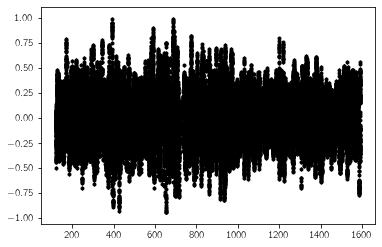

In [4]:
# Load the data
kicid = 1430163
client = kplr.API()
star = client.star(kicid)
x = []
y = []
yerr = []
for lc in star.get_light_curves(short_cadence=False):
    data = lc.read()
    x0 = data["TIME"]
    y0 = data["PDCSAP_FLUX"]
    m = (data["SAP_QUALITY"] == 0) & np.isfinite(x0) & np.isfinite(y0)
    x.append(x0[m])
    mu = np.median(y0[m])
    y.append((y0[m] / mu - 1.0) * 1e3)
    yerr.append(1e3 * data["PDCSAP_FLUX_ERR"][m] / mu)
x = np.concatenate(x)
y = np.concatenate(y)
yerr = np.concatenate(yerr)
inds = np.argsort(x)
t = np.ascontiguousarray(x[inds], dtype=float)
y = np.ascontiguousarray(y[inds], dtype=float)
yerr = np.ascontiguousarray(yerr[inds], dtype=float)

delta_t = np.median(np.diff(t))
y_interp = np.interp(np.arange(t.min(), t.max(), delta_t),
                     t, y)
emp_acorr = emcee.autocorr.function_1d(y_interp) * np.var(y_interp)

plt.errorbar(t, y, yerr=yerr, fmt=".k", lw=1);

4.358326068003487


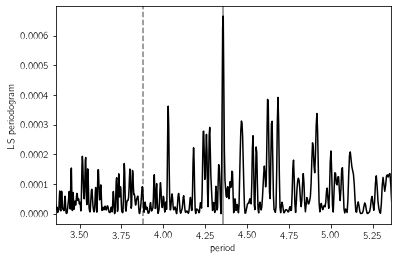

In [5]:
from astropy.timeseries import LombScargle

# First guess at the period
freq = np.linspace(1.0 / 10.0, 1.0 / 1.0, 5000)
model = LombScargle(t, y)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)

period = 1.0 / freq[np.argmax(power)]
print(period)

plt.plot(1.0 / freq, power, "k")

plt.axvline(period, color="k", alpha=0.5)
plt.axvline(3.88, color="k",ls="dashed", alpha=0.5)

plt.xlim(period - 1, period + 1)

plt.xlabel("period")
plt.ylabel("LS periodogram")
plt.savefig("figures/rot-ls.png", bbox_inches="tight")

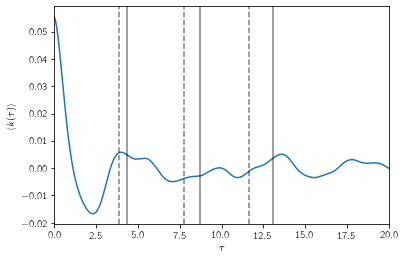

In [6]:
tau = np.arange(len(emp_acorr)) * delta_t
plt.plot(tau, emp_acorr)

plt.axvline(period, color="k", alpha=0.5)
plt.axvline(2*period, color="k", alpha=0.5)
plt.axvline(3*period, color="k", alpha=0.5)

plt.axvline(3.88, color="k",ls="dashed", alpha=0.5)
plt.axvline(2*3.88, color="k",ls="dashed", alpha=0.5)
plt.axvline(3*3.88, color="k",ls="dashed", alpha=0.5)

plt.xlim(0, 20)
plt.ylabel(r"$\left< k(\tau) \right>$")
plt.xlabel(r"$\tau$")

plt.savefig("figures/rot-acor.png", bbox_inches="tight")

In [ ]:
m = (t >= 352.396596505) & (t <= 537.5502295)
t = t[m]
y = y[m]
yerr = yerr[m]

In [ ]:
kernel = terms.TermSum(RotationTerm(
    log_amp=np.log(np.var(y)),
    log_timescale=np.log(10.0),
    log_period=np.log(period),
    log_factor=np.log(1.0),
    bounds=dict(
        log_amp=(-10.0, 0.0),
        log_timescale=(1.5, 5.0),
        log_period=(-3.0, 5.0),
        log_factor=(-5.0, 5.0),
    ),
))

gp = celerite.GP(kernel, mean=np.median(y))
gp.compute(t, yerr)

def neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y[m])

def grad_neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y[m])[1]

# Do another round of sigma clipping using the GP model
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
m = np.ones(len(t), dtype=bool)
for i in range(10):
    gp.compute(t[m], yerr[m])
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y, gp, m))
    gp.set_parameter_vector(soln.x)
    print(soln)
    # initial_params = soln.x
    mu, var = gp.predict(y[m], t, return_var=True)
    sig = np.sqrt(var + yerr**2)
    
    m0 = np.abs(y - mu) < 3 * sig
    print(m0.sum(), m.sum(), np.exp(gp.get_parameter("kernel:terms[0]:log_period")))
    if np.all(m0 == m):
        break
    m = m0
    
fit_t, fit_y, fit_yerr = t[m], y[m], yerr[m]

gp.compute(fit_t, fit_yerr)
print(gp.get_parameter_dict())

ml_gp = copy.deepcopy(gp)
ml_gp.compute(fit_t, fit_yerr)
ml_gp.log_likelihood(fit_y)

In [ ]:
plt.errorbar(t % np.exp(gp.get_parameter("kernel:terms[0]:log_period")), y, yerr=yerr, fmt=".k", lw=1);

In [ ]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--")

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [ ]:
# p = emcee.autocorr.function(y) * np.var(y)

tau = np.linspace(0, 20, 5000)
plt.plot(tau, ml_gp.kernel.get_value(tau))
for k in ml_gp.kernel.terms:
    plt.plot(tau, k.get_value(tau), "--")
plt.ylabel(r"$k(\tau)$")
plt.xlabel(r"$\tau$")

plt.plot(np.arange(len(emp_acorr)) * delta_t, emp_acorr)
plt.axvline(period)
plt.xlim(0, 20)

In [ ]:
plt.plot(t, y, ".k")
plt.plot(t, gp.predict(fit_y, t, return_cov=False))
plt.xlim(375, 425)

In [ ]:
plt.plot(fit_t, fit_y - gp.predict(fit_y, fit_t, return_cov=False), ".k")
plt.ylabel("residuals")
plt.xlabel("time");

In [ ]:
def log_prob(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return lp + gp.log_likelihood(fit_y)

ndim = len(soln.x)
nwalkers = 32
nburn = 500
nsteps = 5000
pos = soln.x + 1e-5 * np.random.randn(nwalkers, ndim)
lp = np.array(list(map(log_prob, pos)))
m = ~np.isfinite(lp)
while np.any(m):
    pos[m] = soln.x + 1e-5 * np.random.randn(m.sum(), ndim)
    lp[m] = np.array(list(map(log_prob, pos[m])))
    m = ~np.isfinite(lp)

pool = emcee.interruptible_pool.InterruptiblePool(2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
pos, _, _ = sampler.run_mcmc(pos, nburn)
sampler.reset()
sampler.run_mcmc(pos, nsteps)
pool.close();

In [ ]:
plt.plot(np.exp(sampler.chain[:, :, 2].T), alpha=0.3);

In [ ]:
gp.get_parameter_names()

In [ ]:
chain = np.concatenate((sampler.flatchain.T, [sampler.flatlnprobability]), axis=0).T
corner.corner(chain);

In [ ]:
t0 = t.min()
x = np.linspace(t0, t0 + 60, 1000)
mu, var = ml_gp.predict(fit_y, x, return_var=True)
std = np.sqrt(var)

fig = plt.figure(figsize=plot_setup.get_figsize(1, 2))

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0), rowspan=1)
ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
fig.subplots_adjust(hspace=0, wspace=0.1)

m = t - t0 < 60
ax1.plot(t[m] - t0, y[m], ".k", ms=3)
m = x - t0 < 60
ax1.plot(x[m] - t0, mu[m], lw=0.75)
ax1.fill_between(x[m]-t0, mu[m]+std[m], mu[m]-std[m],
                 alpha=0.5, edgecolor="none", zorder=100)
ax1.set_xticklabels([])

ax1.annotate("N = {0}".format(len(fit_t)), xy=(0, 0),
             xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom")

pred_mu = ml_gp.predict(fit_y, return_cov=False)
m = fit_t - t0 < 60
ax2.errorbar(fit_t[m] - t0, fit_y[m] - pred_mu[m], fmt=".k", ms=3)
ax2.axhline(0.0, color="k", lw=0.75)

ax1.set_ylim(-1.1, 1.1)
ax1.set_xlim(0., 60)
ax2.set_ylim(-0.09, 0.09)
ax2.set_xlim(0., 60)

ax2.set_xlabel("time [day]")
ax1.set_ylabel("relative flux [ppt]")
ax2.set_ylabel("residuals")

for ax in [ax1, ax2]:
    ax.yaxis.set_label_coords(-0.22, 0.5)

period_samples = np.exp(sampler.flatchain[:, 2])
mu, std = np.mean(period_samples), np.std(period_samples)
n, b, p = ax3.hist(period_samples, 40,
                   color="k", histtype="step", lw=2, normed=True)
ax3.yaxis.set_major_locator(plt.NullLocator())
ax3.set_xlim(b.min(), b.max())
ax3.axvline(3.88, color="k", lw=3, alpha=0.5)
ax3.axvline(mu + std, color="k", ls="dashed")
ax3.axvline(mu - std, color="k", ls="dashed")
ax3.set_xlabel("period [day]")

ax2.xaxis.set_label_coords(0.5, -0.3)
ax3.xaxis.set_label_coords(0.5, -0.1)

fig.savefig("figures/rotation.pdf", bbox_inches="tight", dpi=300, include_diff=False)

In [ ]:
from scipy.linalg import cho_solve, cho_factor

p0 = gp.get_parameter_vector()
fast_timing = %timeit -o log_prob(p0)

def _time_this():
    K = gp.get_matrix(include_diagonal=True)
    factor = cho_factor(K, overwrite_a=True)
    ld = 2.0 * np.sum(np.log(np.diag(factor[0])))
    ll = -0.5*(np.dot(fit_y, cho_solve(factor, fit_y))+ld) + gp.log_prior()

slow_timing = %timeit -o _time_this()

In [ ]:
chain = np.mean(sampler.chain[:, :, 2], axis=0)
tau = emcee.autocorr.integrated_time(chain, c=5)
neff = len(sampler.flatchain) / tau
tau, neff

In [ ]:
import json
c = gp.kernel.coefficients
with open("rotation.json", "w") as f:
    json.dump(dict(
        N=len(t),
        J=len(c[0]) + len(c[2]),
        tau=tau,
        neff=neff,
        time=fast_timing.average,
        direct_time=slow_timing.average,
        nwalkers=nwalkers,
        nburn=nburn,
        nsteps=nsteps,
        ndim=ndim,
    ), f)

In [ ]:
gp.get_parameter_names()

In [ ]:
name_map = {
    'kernel:terms[0]:log_amp': "$\ln(B/\mathrm{ppt}^2)$",
    'kernel:terms[0]:log_timescale': "$\ln(L/\mathrm{day})$",
    'kernel:terms[0]:log_period': "$\ln(P_\mathrm{rot}/\mathrm{day})$",
    'kernel:terms[0]:log_factor': "$\ln(C)$",
}
params = list(zip(
    (name_map[n] for n in gp.get_parameter_names()),
    gp.get_parameter_bounds()
))
with open("rotation-params.json", "w") as f:
    json.dump(params, f)

In [ ]:
period_samps = np.exp(sampler.flatchain[:, 2])
q = np.percentile(period_samps, [16, 50, 84])
print(q, np.diff(q), np.mean(period_samps), np.std(period_samps))

with open("rotation.tex", "w") as f:
    f.write("% Automatically generated\n")
    f.write(("\\newcommand{{\\rotationperiod}}{{\\ensuremath{{{{"
             "{0:.2f} \pm {1:.2f}}}}}}}\n")
            .format(np.mean(period_samps), np.std(period_samps)))